In [ ]:
!nvidia-smi

Wed Jul 10 21:34:35 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A6000               Off | 00000000:01:00.0 Off |                  Off |
| 30%   48C    P2              87W / 300W |  35201MiB / 49140MiB |      4%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!gpustat

In [ ]:
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# Load the data

In [ ]:
# File paths
gpt_crows_results_dir = '../results/crows_Dropout/crows_m-DropoutGPT2LMHeadModel_c-gpt2.json'
gpt_stereoset_results_dir = '../results/stereoset_Dropout_processed/gpt2'
gpt_before_debias_crows_results_dir = '../results/crows/crows_m-GPT2LMHeadModel_c-gpt2.json'
gpt_before_debias_stereoset_results_dir = '../results/stereoset_processed/stereoset_m-GPT2LMHeadModel_c-gpt2_s-42.json'
gpt_training_output_dir = '../results/dropout_FT/gpt2'

In [ ]:
# Load data into dicts
import json

# Load trainer_state.json
with open(f'{gpt_training_output_dir}/trainer_state.json', 'r') as f:
    gpt2_train_state = json.load(f)
# Exclude last entry because it is the final train results
gpt2_train_state = gpt2_train_state["log_history"][:-1]

# Load stereoset data (Before)
with open(f'{gpt_before_debias_stereoset_results_dir}', 'r') as f:
    gpt2_stereoset_results_before = json.load(f)
# Go into first key for before stereoset data
gpt2_stereoset_results_before = gpt2_stereoset_results_before[list(gpt2_stereoset_results_before.keys())[0]]['intrasentence']
    
# Load crows data (Before)
with open(f'{gpt_before_debias_crows_results_dir}', 'r') as f:
    gpt2_crows_results_before = json.load(f)
    
# Load stereoset data (After)
with open(f'{gpt_stereoset_results_dir}/combined.json', 'r') as f:
    gpt2_stereoset_results_after = json.load(f)
    
# Load crows data (After)
with open(gpt_crows_results_dir, 'r') as f:
    gpt2_crows_results_after = json.load(f)

# Visualize the data (GPT2)

## Training step vs crows benchmark

In [ ]:
# Set data
steps = [d['step'] for d in gpt2_train_state]
gender_scores = {}
race_scores = {}
religion_scores = {}
# Extract gender stereotype scores
for key, value in gpt2_crows_results_after.items():
    gender_scores[key] = value['gender']['Stereotype score']
    race_scores[key] = value['race-color']['Stereotype score']
    religion_scores[key] = value['religion']['Stereotype score']

# Sort the steps and scores in step order
steps = sorted([int(step) for step in gender_scores.keys()])
gender_scores = [gender_scores[str(step)] for step in steps]
race_scores = [race_scores[str(step)] for step in steps]
religion_scores = [religion_scores[str(step)] for step in steps]

# Extract before debias stereoset benchmark data
crows_before_debias_ss_gender = gpt2_crows_results_before['gender']['Stereotype score']
crows_before_debias_ss_race = gpt2_crows_results_before['race-color']['Stereotype score']
crows_before_debias_ss_religion = gpt2_crows_results_before['religion']['Stereotype score']

In [ ]:
import matplotlib.pyplot as plt
import os
import numpy as np

# Plot crows stereotype score vs step
# Left axis: crows stereotype score for 3 categories gender, race, religion
# Bottom axis: Step

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Function to plot a line and label its max and min points
def plot_line_with_labels(ax, x, y, color, label):
    line, = ax.plot(x, y, color=color, label=label)
    
    # Find max and min points
    max_index = np.argmax(y)
    min_index = np.argmin(y)
    
    # Label max point
    ax.annotate(f'Max:{y[max_index]:.2f}', 
                (x[max_index], y[max_index]),
                xytext=(5, 5), textcoords='offset points',
                color=color, fontweight='bold')
    
    # Label min point
    ax.annotate(f'Min:{y[min_index]:.2f}', 
                (x[min_index], y[min_index]),
                xytext=(5, -15), textcoords='offset points',
                color=color, fontweight='bold')
    
    return line

# Plot CROWS stereotype scores with labels
gender_line = plot_line_with_labels(ax, steps, gender_scores, 'blue', 'Gender Dropout')
race_line = plot_line_with_labels(ax, steps, race_scores, 'green', 'Race Dropout')
religion_line = plot_line_with_labels(ax, steps, religion_scores, 'red', 'Religion Dropout')

# Set labels and title
ax.set_xlabel('Steps')
ax.set_ylabel('CROWS Stereotype Score')
ax.set_title('CROWS Stereotype Scores vs. Steps')

# Draw line for original stereotype score crows and add labels
ax.axhline(y=crows_before_debias_ss_gender, color='tab:blue', linestyle='dotted', label='Gender (Original)')
# ax.text(ax.get_xlim()[1], stereoset_before_debias_ss_gender, f' {stereoset_before_debias_ss_gender:.2f}', 
#         va='center', ha='left', color='tab:blue')

ax.axhline(y=crows_before_debias_ss_race, color='tab:green', linestyle='dotted', label='Race (Original)')
# ax.text(ax.get_xlim()[1], stereoset_before_debias_ss_race, f' {stereoset_before_debias_ss_race:.2f}', 
#         va='center', ha='left', color='tab:green')

ax.axhline(y=crows_before_debias_ss_religion, color='tab:red', linestyle='dotted', label='Religion (Original)')
# ax.text(ax.get_xlim()[1], stereoset_before_debias_ss_religion, f' {stereoset_before_debias_ss_religion:.2f}', 
#         va='center', ha='left', color='tab:red')

# Add legend
ax.legend(loc='upper right')

# Add grid
plt.grid(True, alpha=0.3)

# Adjust x-axis ticks
plt.xticks(steps[::2], rotation=45)  # Show every other step label, rotated 45 degrees

# Show the plot
plt.tight_layout()
plt.show()

# Save chart in media dir
fig.savefig('media/dropout/gpt2_dropout_crows.png')

# Training step vs stereoset benchmark

In [ ]:
# Set data
steps = [d['step'] for d in gpt2_train_state]
gender_scores = {}
race_scores = {}
religion_scores = {}
# Extract gender stereotype scores
for key, value in gpt2_stereoset_results_after.items():
    gender_scores[key] = value['intrasentence']['gender']['SS Score']
    race_scores[key] = value['intrasentence']['race']['SS Score']
    religion_scores[key] = value['intrasentence']['religion']['SS Score']
    
# Sort the steps and scores in step order
steps = sorted([int(step) for step in gender_scores.keys()])
gender_scores = [gender_scores[str(step)] for step in steps]
race_scores = [race_scores[str(step)] for step in steps]
religion_scores = [religion_scores[str(step)] for step in steps]

# Extract before debias stereoset benchmark data
stereoset_before_debias_ss_gender = gpt2_stereoset_results_before['gender']['SS Score']
stereoset_before_debias_ss_race = gpt2_stereoset_results_before['race']['SS Score']
stereoset_before_debias_ss_religion = gpt2_stereoset_results_before['religion']['SS Score']

In [ ]:
import matplotlib.pyplot as plt
import os
import numpy as np

# Plot crows stereotype score vs step
# Left axis: crows stereotype score for 3 categories gender, race, religion
# Bottom axis: Step

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Function to plot a line and label its max and min points
def plot_line_with_labels(ax, x, y, color, label):
    line, = ax.plot(x, y, color=color, label=label)
    
    # Find max and min points
    max_index = np.argmax(y)
    min_index = np.argmin(y)
    
    # Label max point
    ax.annotate(f'Max:{y[max_index]:.2f}', 
                (x[max_index], y[max_index]),
                xytext=(5, 5), textcoords='offset points',
                color=color, fontweight='bold')
    
    # Label min point
    ax.annotate(f'Min:{y[min_index]:.2f}', 
                (x[min_index], y[min_index]),
                xytext=(5, -15), textcoords='offset points',
                color=color, fontweight='bold')
    
    return line

# Plot CROWS stereotype scores with labels
gender_line = plot_line_with_labels(ax, steps, gender_scores, 'blue', 'Gender Dropout')
race_line = plot_line_with_labels(ax, steps, race_scores, 'green', 'Race Dropout')
religion_line = plot_line_with_labels(ax, steps, religion_scores, 'red', 'Religion Dropout')

# Set labels and title
ax.set_xlabel('Steps')
ax.set_ylabel('Stereoset Stereotype Score')
ax.set_title('Stereoset Stereotype Scores vs. Steps')

# Draw line for original stereotype score crows and add labels
ax.axhline(y=stereoset_before_debias_ss_gender, color='tab:blue', linestyle='dotted', label='Gender (Original)')
# ax.text(ax.get_xlim()[1], stereoset_before_debias_ss_gender, f' {stereoset_before_debias_ss_gender:.2f}', 
#         va='center', ha='left', color='tab:blue')

ax.axhline(y=stereoset_before_debias_ss_race, color='tab:green', linestyle='dotted', label='Race (Original)')
# ax.text(ax.get_xlim()[1], stereoset_before_debias_ss_race, f' {stereoset_before_debias_ss_race:.2f}', 
#         va='center', ha='left', color='tab:green')

ax.axhline(y=stereoset_before_debias_ss_religion, color='tab:red', linestyle='dotted', label='Religion (Original)')
# ax.text(ax.get_xlim()[1], stereoset_before_debias_ss_religion, f' {stereoset_before_debias_ss_religion:.2f}', 
#         va='center', ha='left', color='tab:red')

# Add legend
ax.legend(loc='upper right')

# Add grid
plt.grid(True, alpha=0.3)

# Adjust x-axis ticks
plt.xticks(steps[::2], rotation=45)  # Show every other step label, rotated 45 degrees

# Show the plot
plt.tight_layout()
plt.show()

# Save chart in media dir
fig.savefig('media/dropout/gpt2_dropout_stereoset.png')

# Loss vs step

In [ ]:
import matplotlib.pyplot as plt
import os
import numpy as np

# Plot training loss vs step
# Left axis: loss
# Bottom axis: Step

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Extract key values from training data
steps = [d['step'] for d in gpt2_train_state]
loss = [d['loss'] for d in gpt2_train_state]
learning_rate = [d['learning_rate'] for d in gpt2_train_state]


# Plot loss vs step on the primary y-axis
ax1.plot(steps, loss, label='Gender Loss', color='blue')

# Set labels and title for the primary y-axis
ax1.set_xlabel('Step')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss and Learning Rate vs Step')

# Adjust y-axis to start from 0
ax1.set_ylim(bottom=0)

# Create a secondary y-axis for learning rate
ax2 = ax1.twinx()
ax2.plot(steps, learning_rate, label='Learning Rate', color='purple', linestyle='--')
ax2.set_ylabel('Learning Rate')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Add grid
ax1.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

# Save chart in media dir
fig.savefig('media/dropout/gpt2_dropout_loss_step.png')

# Phi 2

In [1]:
# File paths
phi_crows_results_dir = '../results/crows_Dropout/crows_m-DropoutPhi2LMHeadModel_c-microsoft_phi-2.json'
phi_stereoset_results_dir = '../results/stereoset_Dropout_processed/phi2'
phi_before_debias_crows_results_dir = '../results/crows/crows_m-PhiForCausalLM_c-microsoft_phi-2.json'
phi_before_debias_stereoset_results_dir = '../results/stereoset_processed/stereoset_m-PhiForCausalLM_c-microsoft_phi-2_s-42.json'
phi_training_output_dir = '../results/dropout_FT/phi2'

In [2]:
# Load data into dicts
import json

# Load trainer_state.json
with open(f'{phi_training_output_dir}/trainer_state.json', 'r') as f:
    phi2_train_state = json.load(f)
# Exclude last entry because it is the final train results
phi2_train_state = phi2_train_state["log_history"][:-1]

# Load stereoset data (Before)
with open(f'{phi_before_debias_stereoset_results_dir}', 'r') as f:
    phi2_stereoset_results_before = json.load(f)
# Go into first key for before stereoset data
phi2_stereoset_results_before = phi2_stereoset_results_before[list(phi2_stereoset_results_before.keys())[0]]['intrasentence']
    
# Load crows data (Before)
with open(f'{phi_before_debias_crows_results_dir}', 'r') as f:
    phi2_crows_results_before = json.load(f)
    
# Load stereoset data (After)
with open(f'{phi_stereoset_results_dir}/combined.json', 'r') as f:
    phi2_stereoset_results_after = json.load(f)
    
# Load crows data (After)
with open(phi_crows_results_dir, 'r') as f:
    phi2_crows_results_after = json.load(f)

# Training step vs crows benchmark

In [3]:
# Set data
steps = [d['step'] for d in phi2_train_state]
gender_scores = {}
race_scores = {}
religion_scores = {}
# Extract gender stereotype scores
for key, value in phi2_crows_results_after.items():
    gender_scores[key] = value['gender']['Stereotype score']
    race_scores[key] = value['race-color']['Stereotype score']
    religion_scores[key] = value['religion']['Stereotype score']

# Sort the steps and scores in step order
steps = sorted([int(step) for step in gender_scores.keys()])
gender_scores = [gender_scores[str(step)] for step in steps]
race_scores = [race_scores[str(step)] for step in steps]
religion_scores = [religion_scores[str(step)] for step in steps]

# Extract before debias stereoset benchmark data
crows_before_debias_ss_gender = phi2_crows_results_before['gender']['Stereotype score']
crows_before_debias_ss_race = phi2_crows_results_before['race-color']['Stereotype score']
crows_before_debias_ss_religion = phi2_crows_results_before['religion']['Stereotype score']

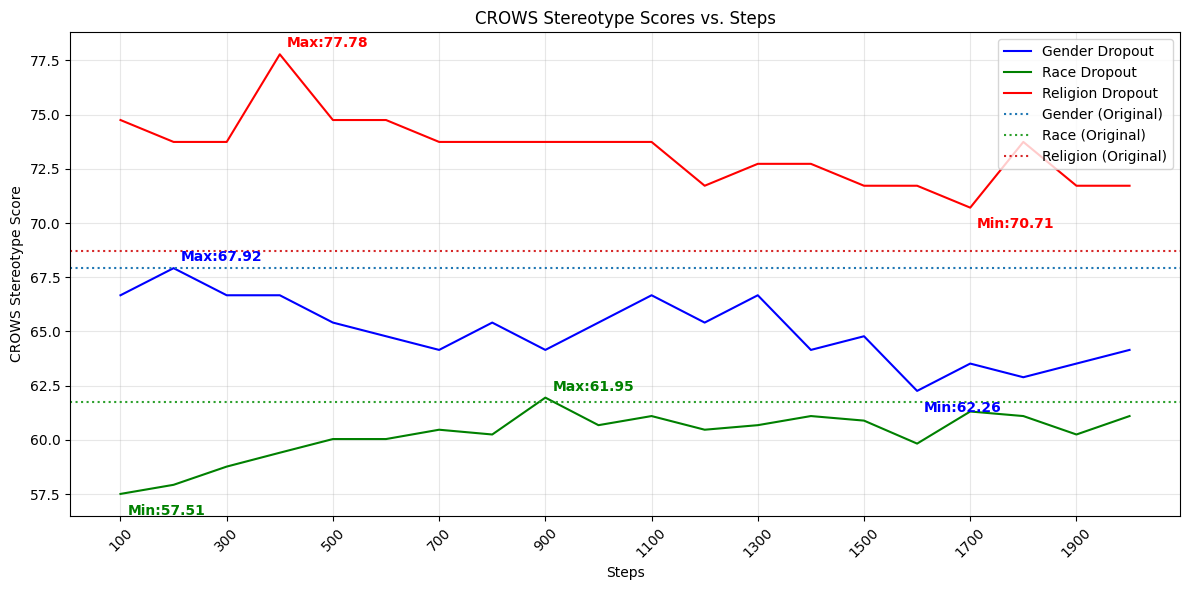

In [4]:
import matplotlib.pyplot as plt
import os
import numpy as np

# Plot crows stereotype score vs step
# Left axis: crows stereotype score for 3 categories gender, race, religion
# Bottom axis: Step

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Function to plot a line and label its max and min points
def plot_line_with_labels(ax, x, y, color, label):
    line, = ax.plot(x, y, color=color, label=label)
    
    # Find max and min points
    max_index = np.argmax(y)
    min_index = np.argmin(y)
    
    # Label max point
    ax.annotate(f'Max:{y[max_index]:.2f}', 
                (x[max_index], y[max_index]),
                xytext=(5, 5), textcoords='offset points',
                color=color, fontweight='bold')
    
    # Label min point
    ax.annotate(f'Min:{y[min_index]:.2f}', 
                (x[min_index], y[min_index]),
                xytext=(5, -15), textcoords='offset points',
                color=color, fontweight='bold')
    
    return line

# Plot CROWS stereotype scores with labels
gender_line = plot_line_with_labels(ax, steps, gender_scores, 'blue', 'Gender Dropout')
race_line = plot_line_with_labels(ax, steps, race_scores, 'green', 'Race Dropout')
religion_line = plot_line_with_labels(ax, steps, religion_scores, 'red', 'Religion Dropout')

# Set labels and title
ax.set_xlabel('Steps')
ax.set_ylabel('CROWS Stereotype Score')
ax.set_title('CROWS Stereotype Scores vs. Steps')

# Draw line for original stereotype score crows and add labels
ax.axhline(y=crows_before_debias_ss_gender, color='tab:blue', linestyle='dotted', label='Gender (Original)')
# ax.text(ax.get_xlim()[1], stereoset_before_debias_ss_gender, f' {stereoset_before_debias_ss_gender:.2f}', 
#         va='center', ha='left', color='tab:blue')

ax.axhline(y=crows_before_debias_ss_race, color='tab:green', linestyle='dotted', label='Race (Original)')
# ax.text(ax.get_xlim()[1], stereoset_before_debias_ss_race, f' {stereoset_before_debias_ss_race:.2f}', 
#         va='center', ha='left', color='tab:green')

ax.axhline(y=crows_before_debias_ss_religion, color='tab:red', linestyle='dotted', label='Religion (Original)')
# ax.text(ax.get_xlim()[1], stereoset_before_debias_ss_religion, f' {stereoset_before_debias_ss_religion:.2f}', 
#         va='center', ha='left', color='tab:red')

# Add legend
ax.legend(loc='upper right')

# Add grid
plt.grid(True, alpha=0.3)

# Adjust x-axis ticks
plt.xticks(steps[::2], rotation=45)  # Show every other step label, rotated 45 degrees

# Show the plot
plt.tight_layout()
plt.show()

# Save chart in media dir
fig.savefig('media/dropout/phi2_dropout_crows.png')

# Training step vs stereoset benchmark

In [5]:
# Set data
steps = [d['step'] for d in phi2_train_state]
gender_scores = {}
race_scores = {}
religion_scores = {}
# Extract gender stereotype scores
for key, value in phi2_stereoset_results_after.items():
    gender_scores[key] = value['intrasentence']['gender']['SS Score']
    race_scores[key] = value['intrasentence']['race']['SS Score']
    religion_scores[key] = value['intrasentence']['religion']['SS Score']
    
# Sort the steps and scores in step order
steps = sorted([int(step) for step in gender_scores.keys()])
gender_scores = [gender_scores[str(step)] for step in steps]
race_scores = [race_scores[str(step)] for step in steps]
religion_scores = [religion_scores[str(step)] for step in steps]

# Extract before debias stereoset benchmark data
stereoset_before_debias_ss_gender = phi2_stereoset_results_before['gender']['SS Score']
stereoset_before_debias_ss_race = phi2_stereoset_results_before['race']['SS Score']
stereoset_before_debias_ss_religion = phi2_stereoset_results_before['religion']['SS Score']

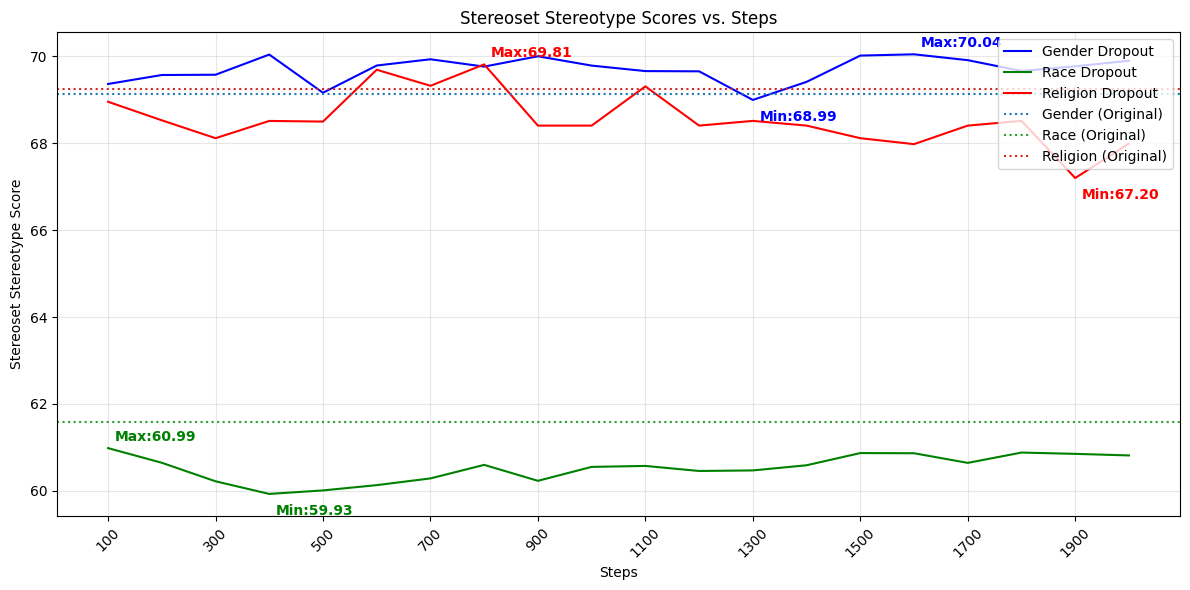

In [6]:
import matplotlib.pyplot as plt
import os
import numpy as np

# Plot crows stereotype score vs step
# Left axis: crows stereotype score for 3 categories gender, race, religion
# Bottom axis: Step

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Function to plot a line and label its max and min points
def plot_line_with_labels(ax, x, y, color, label):
    line, = ax.plot(x, y, color=color, label=label)
    
    # Find max and min points
    max_index = np.argmax(y)
    min_index = np.argmin(y)
    
    # Label max point
    ax.annotate(f'Max:{y[max_index]:.2f}', 
                (x[max_index], y[max_index]),
                xytext=(5, 5), textcoords='offset points',
                color=color, fontweight='bold')
    
    # Label min point
    ax.annotate(f'Min:{y[min_index]:.2f}', 
                (x[min_index], y[min_index]),
                xytext=(5, -15), textcoords='offset points',
                color=color, fontweight='bold')
    
    return line

# Plot CROWS stereotype scores with labels
gender_line = plot_line_with_labels(ax, steps, gender_scores, 'blue', 'Gender Dropout')
race_line = plot_line_with_labels(ax, steps, race_scores, 'green', 'Race Dropout')
religion_line = plot_line_with_labels(ax, steps, religion_scores, 'red', 'Religion Dropout')

# Set labels and title
ax.set_xlabel('Steps')
ax.set_ylabel('Stereoset Stereotype Score')
ax.set_title('Stereoset Stereotype Scores vs. Steps')

# Draw line for original stereotype score crows and add labels
ax.axhline(y=stereoset_before_debias_ss_gender, color='tab:blue', linestyle='dotted', label='Gender (Original)')
# ax.text(ax.get_xlim()[1], stereoset_before_debias_ss_gender, f' {stereoset_before_debias_ss_gender:.2f}', 
#         va='center', ha='left', color='tab:blue')

ax.axhline(y=stereoset_before_debias_ss_race, color='tab:green', linestyle='dotted', label='Race (Original)')
# ax.text(ax.get_xlim()[1], stereoset_before_debias_ss_race, f' {stereoset_before_debias_ss_race:.2f}', 
#         va='center', ha='left', color='tab:green')

ax.axhline(y=stereoset_before_debias_ss_religion, color='tab:red', linestyle='dotted', label='Religion (Original)')
# ax.text(ax.get_xlim()[1], stereoset_before_debias_ss_religion, f' {stereoset_before_debias_ss_religion:.2f}', 
#         va='center', ha='left', color='tab:red')

# Add legend
ax.legend(loc='upper right')

# Add grid
plt.grid(True, alpha=0.3)

# Adjust x-axis ticks
plt.xticks(steps[::2], rotation=45)  # Show every other step label, rotated 45 degrees

# Show the plot
plt.tight_layout()
plt.show()

# Save chart in media dir
fig.savefig('media/dropout/phi2_dropout_stereoset.png')

# Loss vs step

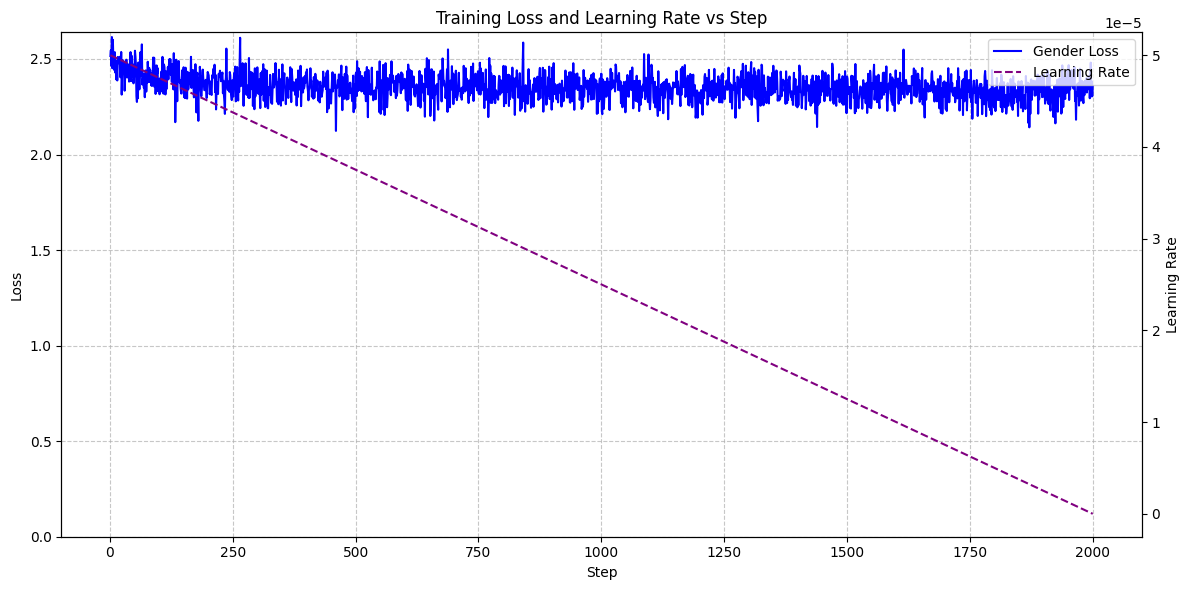

In [7]:
import matplotlib.pyplot as plt
import os
import numpy as np

# Plot training loss vs step
# Left axis: loss
# Bottom axis: Step

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Extract key values from training data
steps = [d['step'] for d in phi2_train_state]
loss = [d['loss'] for d in phi2_train_state]
learning_rate = [d['learning_rate'] for d in phi2_train_state]


# Plot loss vs step on the primary y-axis
ax1.plot(steps, loss, label='Gender Loss', color='blue')

# Set labels and title for the primary y-axis
ax1.set_xlabel('Step')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss and Learning Rate vs Step')

# Adjust y-axis to start from 0
ax1.set_ylim(bottom=0)

# Create a secondary y-axis for learning rate
ax2 = ax1.twinx()
ax2.plot(steps, learning_rate, label='Learning Rate', color='purple', linestyle='--')
ax2.set_ylabel('Learning Rate')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Add grid
ax1.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

# Save chart in media dir
fig.savefig('media/dropout/phi2_dropout_loss_step.png')